The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...
Loaded all components successfully!
Original shapes: Y=torch.Size([407878, 348, 52]), E=torch.Size([407878, 348]), G=torch.Size([407878, 36])
New shapes: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=torch.Size([10000, 36])


/home/surbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/home/surbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Lambda kernel condition number: 402362656.00
Phi kernel condition number: 1310707584.00


/home/surbut/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 74 diseases
Cluster 2: 30 diseases
Cluster 3: 7 diseases
Cluster 4: 23 diseases
Cluster 5: 10 diseases
Cluster 6: 17 diseases
Cluster 7: 14 diseases
Cluster 8: 21 diseases
Cluster 9: 5 diseases
Cluster 10: 8 diseases
Cluster 11: 9 diseases
Cluster 12: 12 diseases
Cluster 13: 31 diseases
Cluster 14: 25 diseases
Cluster 15: 5 diseases
Cluster 16: 9 diseases
Cluster 17: 17 diseases
Cluster 18: 11 diseases
Cluster 19: 9 diseases
Initialization complete!

Using psi configuration
Initialization complete!


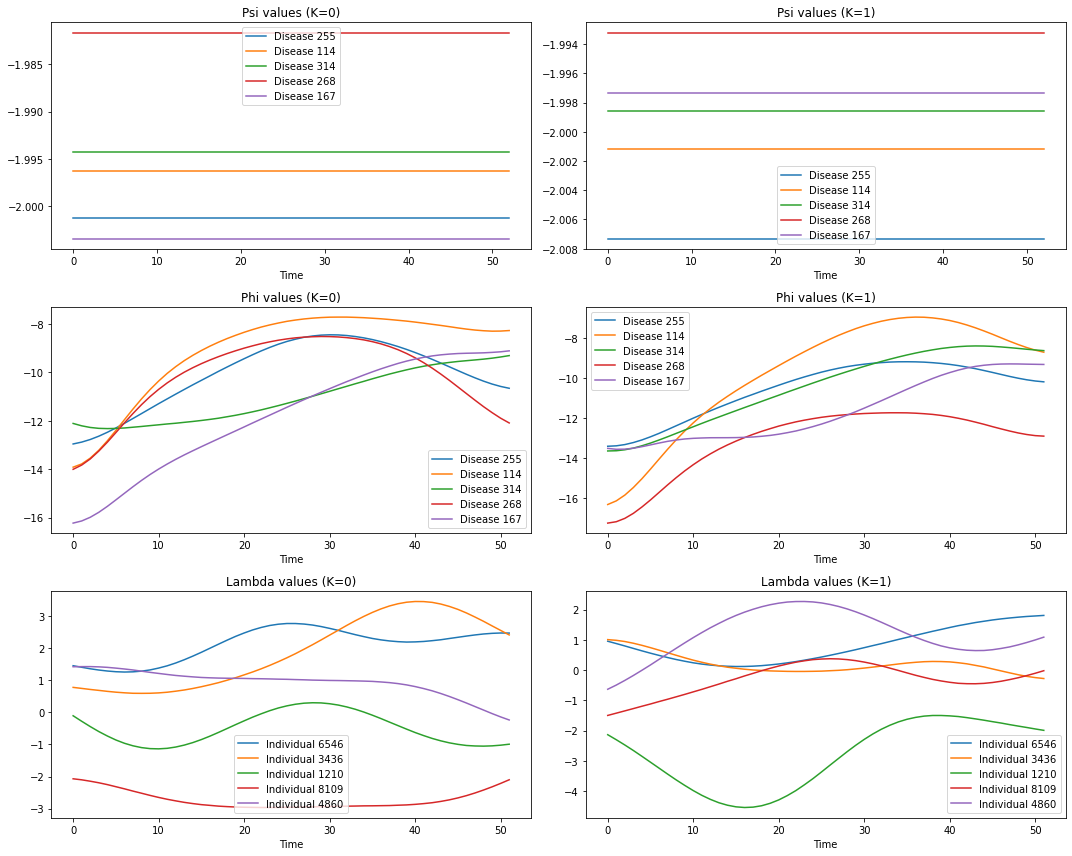


Cluster membership for sampled diseases:
Disease 255: Cluster 13
Disease 114: Cluster 3
Disease 314: Cluster 4
Disease 268: Cluster 14
Disease 167: Cluster 18


/home/surbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:617: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


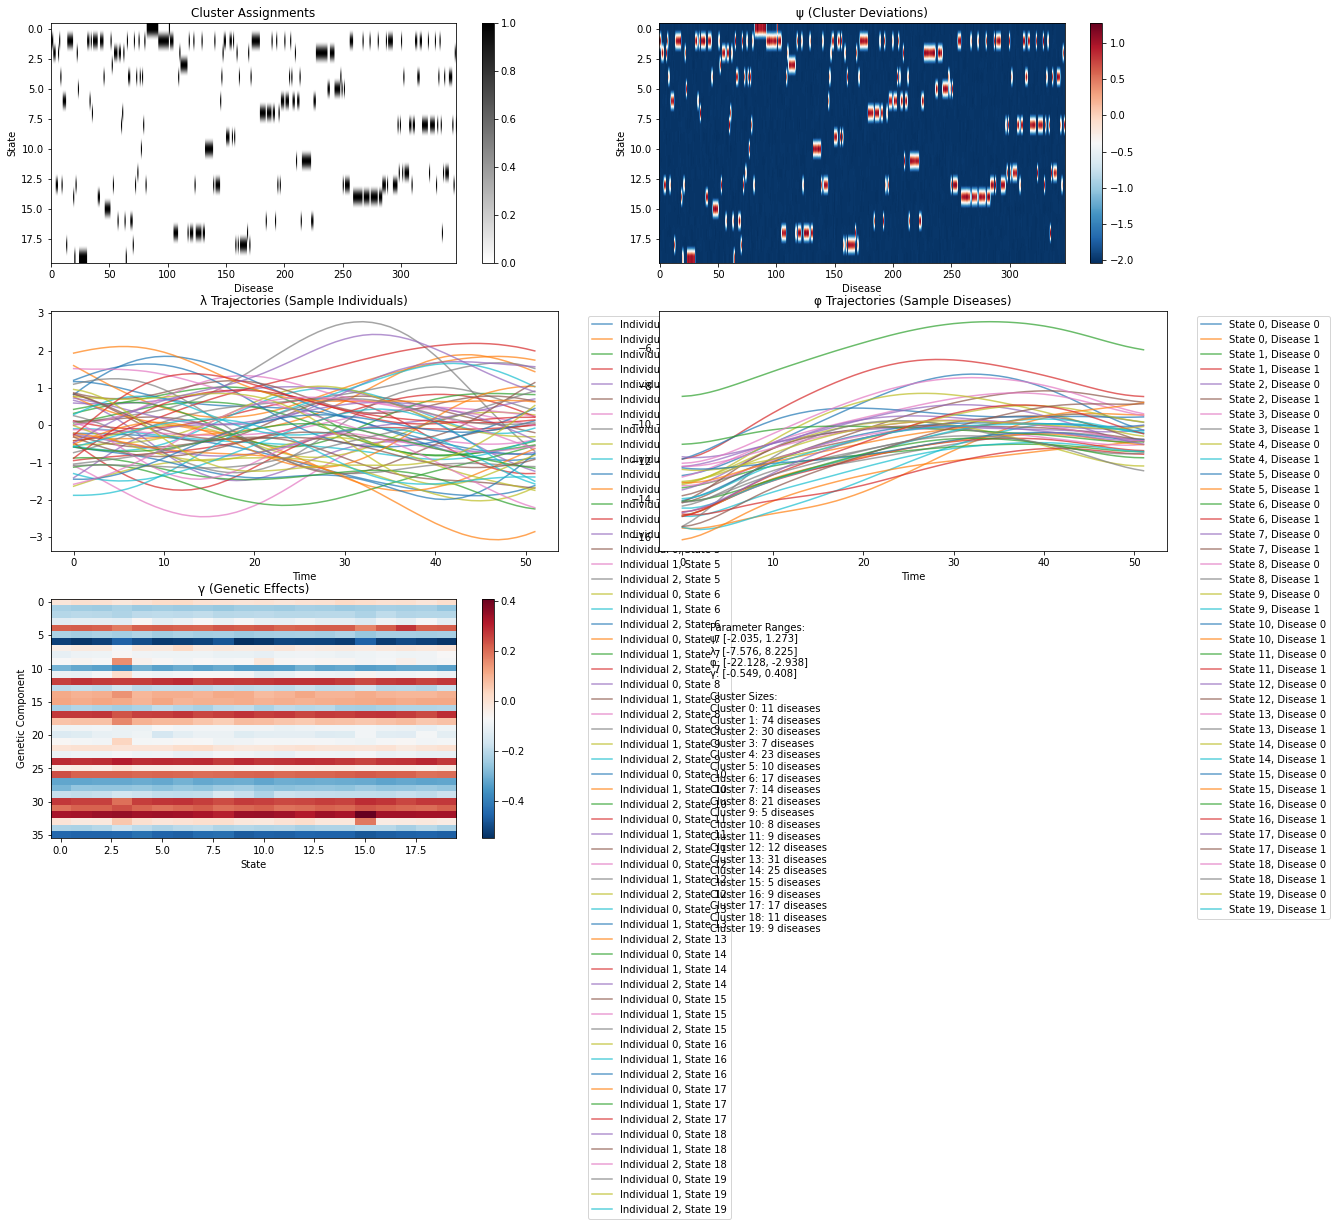

Starting training...


/home/surbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 0
Loss: 1109.1042
Psi gradient stats:
Mean: -4.0411e-05
Std:  4.7476e-03
Max:  1.7128e-02
Min:  -1.9234e-02
Average psi change: 9.9944e-05
Epoch 0, Loss: 1109.1042, Gradients - Lambda: 5.388e-01, Phi: 1.478e+01, Gamma: 6.277e-02, Psi: 1.923e-02
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 1
Loss: 837.7710
Psi gradient stats:
Mean: -3.9680e-05
Std:  4.7326e-03
Max:  1.7109e-02
Min:  -1.9262e-02
Average psi change: 9.9215e-05
Epoch 1, Loss: 837.7710, Gradients - Lambda: 4.943e-01, Phi: 1.306e+01, Gamma: 6.150e-02, Psi: 1.926e-02

Estimated total training time: 601.7 minutes
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 2
Loss: 644.8679
Psi gradient stats:
Mean: -3.9029e-05
Std:  4.7168e-03
Max:  1.7117e-02
Min:  -1.9278e-02
Average psi change: 9.8939

In [1]:
%load_ext autoreload
%autoreload 2
from optimize_psi import *
from cluster_g_logit_init_acceptpsi import *
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/home/surbut/Downloads/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


def subset_data(Y, E, G, n_samples=50000, seed=42):
    """
    Subset the data to n_samples individuals while maintaining consistency
    
    Args:
        Y: tensor of shape [N, D, T]
        E: tensor of shape [N, D]
        G: tensor of shape [N, P]
        n_samples: number of individuals to keep
        seed: random seed for reproducibility
    
    Returns:
        Y_sub, E_sub, G_sub: subsetted tensors
    """
    torch.manual_seed(seed)
    
    # Get total number of individuals
    N = Y.shape[0]
    
    # Randomly select n_samples indices
    indices = torch.randperm(N)[:n_samples]
    
    # Subset all matrices using the same indices
    Y_sub = Y[indices]
    E_sub = E[indices]
    G_sub = G[indices]
    
    print(f"Original shapes: Y={Y.shape}, E={E.shape}, G={G.shape}")
    print(f"New shapes: Y={Y_sub.shape}, E={E_sub.shape}, G={G_sub.shape}")
    
    return Y_sub, E_sub, G_sub, indices

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, n_samples=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data

psi_config = {'in_cluster': 1, 'out_cluster': -2, 'noise_in': 0.1, 'noise_out': 0.01}
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0],
    D=Y_100k.shape[1],
    T=Y_100k.shape[2],
    K=essentials['K'],
    P=essentials['P'],
    G=G_100k,
    Y=Y_100k,
    prevalence_t=essentials['prevalence_t']
)

model.initialize_params(psi_config=psi_config)
model.plot_initial_params()
model.visualize_initialization()
model.psi

history = model.fit(E_100k, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)
        

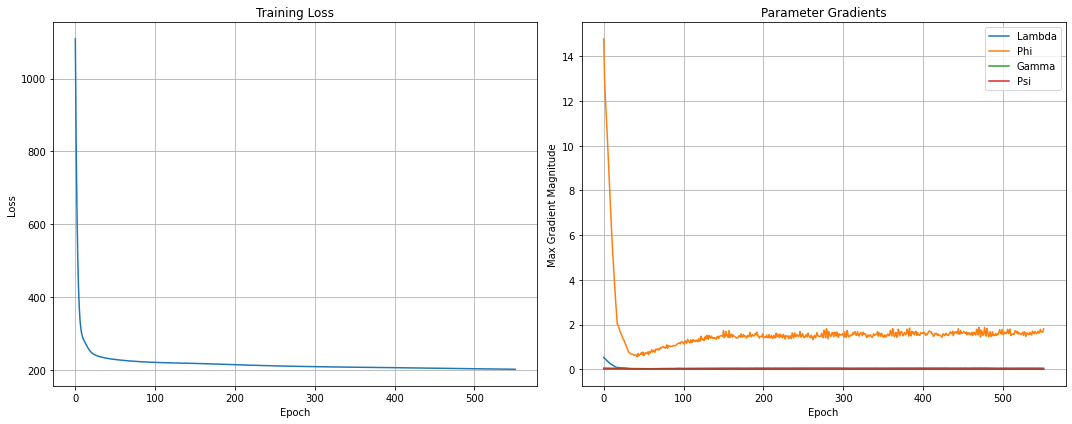

In [2]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history['max_grad_lambda'], label='Lambda')
ax2.plot(history['max_grad_phi'], label='Phi')
ax2.plot(history['max_grad_gamma'], label='Gamma')
ax2.plot(history['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [5]:
disease_names=essentials['disease_names']

In [6]:
import torch

# Save complete state for R
save_path = '12model_complete_for_R_127.pt'

torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t':essentials['prevalence_t'],
    'G': G_100k,
    'E': E,
    'indices' : indices,
    'disease_names': disease_names,
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T':Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, save_path)

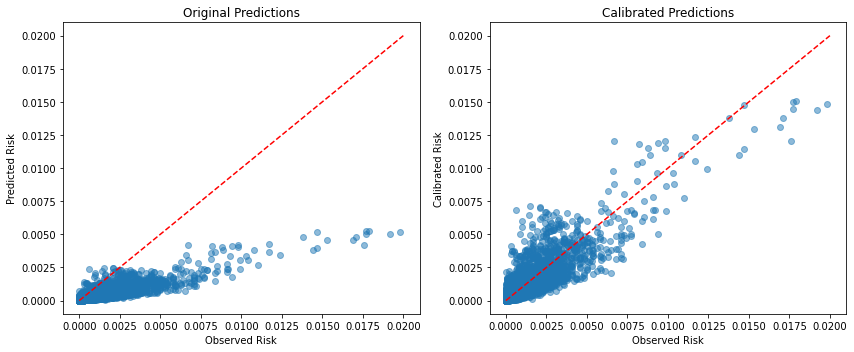

Mean observed risk: 0.000451
Mean predicted risk (original): 0.000158
Mean predicted risk (calibrated): 0.000451
Calibration scale factor: 2.862


In [7]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [8]:

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.776


In [10]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, disease_names)


Top 10 diseases in Signature 0 (relative to baseline):
Retinal vascular changes and abnomalities: effect=1.869 (OR=6.48), std=0.418
Other retinal disorders: effect=1.449 (OR=4.26), std=0.267
Myopia: effect=1.313 (OR=3.72), std=0.643
Retinal detachment with retinal defect: effect=1.310 (OR=3.71), std=0.200
Glaucoma: effect=1.264 (OR=3.54), std=0.588
Cataract: effect=1.162 (OR=3.20), std=0.350
Disorders of vitreous body: effect=0.592 (OR=1.81), std=0.663
Primary open angle glaucoma: effect=0.591 (OR=1.81), std=0.381
Abdominal pain: effect=0.175 (OR=1.19), std=1.010
Ptosis of eyelid: effect=0.171 (OR=1.19), std=0.557

Top 10 diseases in Signature 1 (relative to baseline):
Bacterial enteritis: effect=3.062 (OR=21.37), std=0.438
Facial nerve disorders [CN7]: effect=2.765 (OR=15.88), std=0.216
Seborrheic keratosis: effect=2.109 (OR=8.24), std=0.299
Other disorders of bone and cartilage: effect=2.052 (OR=7.78), std=0.505
Acute upper respiratory infections of multiple or unspecified sites: ef

In [12]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, disease_names)


Signature 0:

Initial top diseases:
1. Other retinal disorders: 1.303
2. Glaucoma: 1.106
3. Myopia: 1.054
4. Retinal detachment with retinal defect: 1.028
5. Retinal vascular changes and abnomalities: 0.999
6. Senile cataract: 0.918
7. Retinal detachments and defects: 0.917
8. Cataract: 0.911
9. Macular degeneration (senile) of retina NOS: 0.854
10. Disorders of vitreous body: 0.799

Final top diseases:
1. Retinal vascular changes and abnomalities: 1.869
2. Other retinal disorders: 1.449
3. Myopia: 1.313
4. Retinal detachment with retinal defect: 1.310
5. Glaucoma: 1.264
6. Cataract: 1.162
7. Disorders of vitreous body: 0.592
8. Primary open angle glaucoma: 0.591
9. Abdominal pain: 0.175
10. Ptosis of eyelid: 0.171

Retinal detachments and defects changed from rank 7 to 12

Macular degeneration (senile) of retina NOS changed from rank 9 to 12

Retinal vascular changes and abnomalities changed from rank 5 to 1

Glaucoma changed from rank 2 to 5

Primary open angle glaucoma changed from


Cluster Assignments:

Cluster 0:
  - Retinal detachments and defects (prevalence: 0.0002)
  - Retinal detachment with retinal defect (prevalence: 0.0001)
  - Other retinal disorders (prevalence: 0.0001)
  - Macular degeneration (senile) of retina NOS (prevalence: 0.0005)
  - Retinal vascular changes and abnomalities (prevalence: 0.0001)
  - Glaucoma (prevalence: 0.0006)
  - Primary open angle glaucoma (prevalence: 0.0001)
  - Cataract (prevalence: 0.0021)
  - Senile cataract (prevalence: 0.0017)
  - Myopia (prevalence: 0.0002)
  - Disorders of vitreous body (prevalence: 0.0002)

Cluster 1:
  - Bacterial enteritis (prevalence: 0.0002)
  - Viral Enteritis (prevalence: 0.0001)
  - Viral warts & HPV (prevalence: 0.0001)
  - Melanomas of skin (prevalence: 0.0003)
  - Other non-epithelial cancer of skin (prevalence: 0.0011)
  - Breast cancer [female] (prevalence: 0.0002)
  - Malignant neoplasm of female breast (prevalence: 0.0008)
  - Cervical intraepithelial neoplasia [CIN] [Cervical dyspl

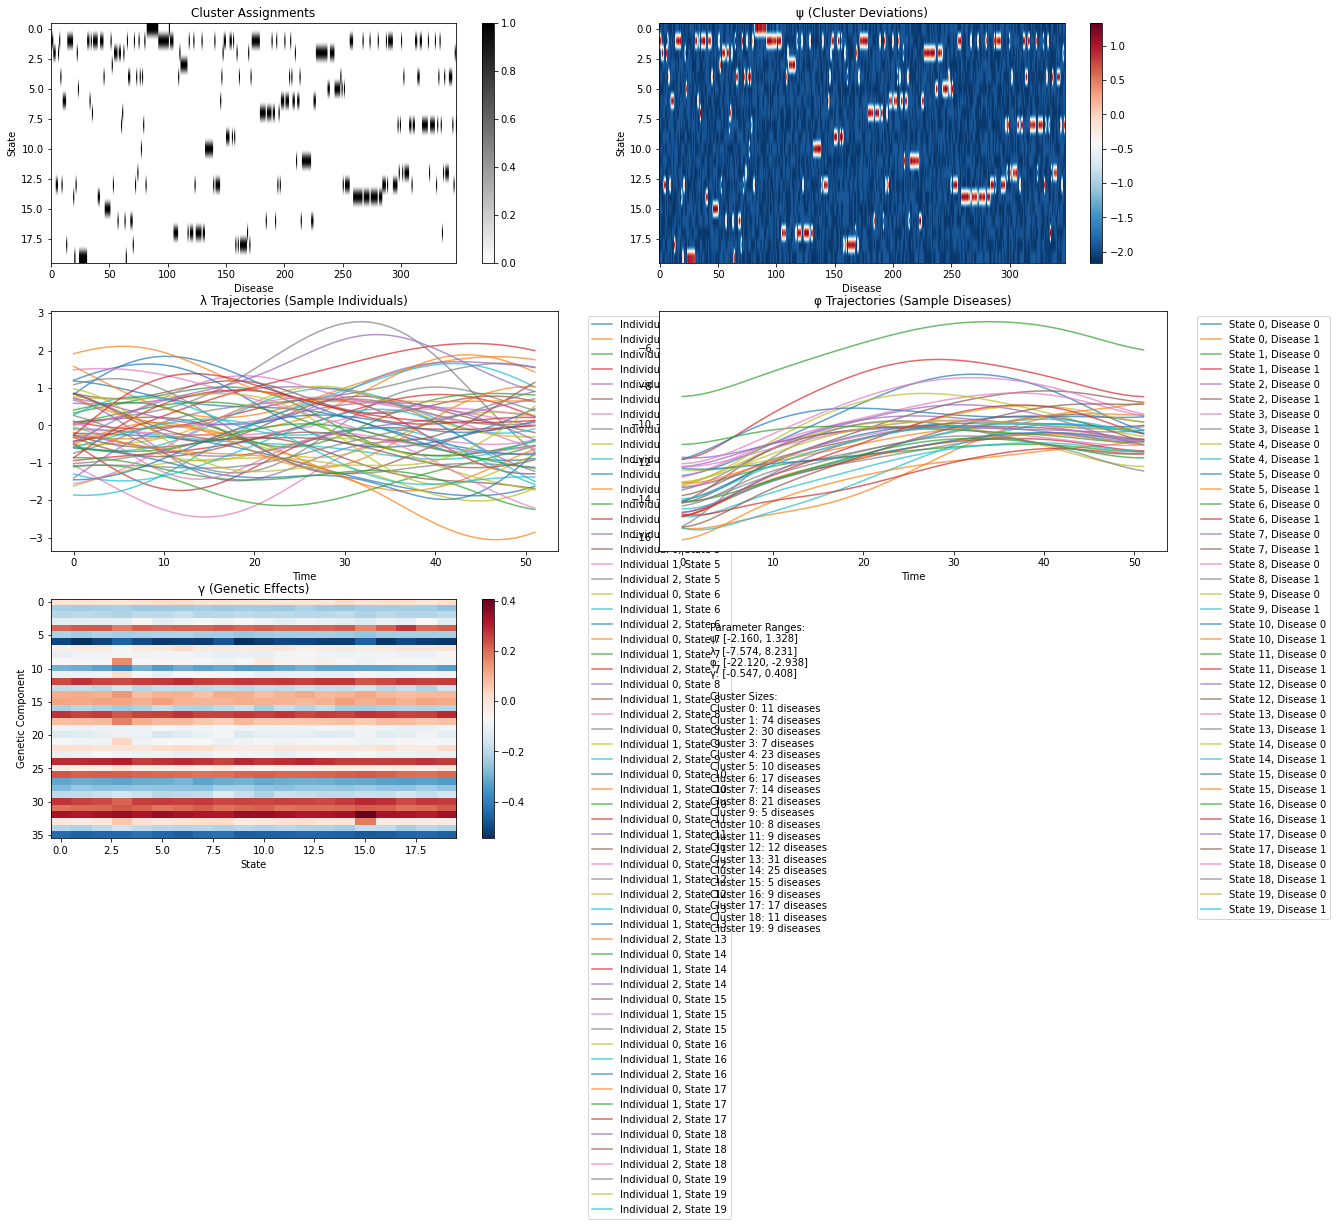

In [13]:

model.visualize_clusters(disease_names)
model.visualize_initialization()

In [ ]:
def plot_signature_temporal_patterns(model, disease_names, n_top=10, selected_signatures=None):
    """
    Show temporal patterns of top diseases for each signature
    """
    #phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    #phi_avg = phi.mean(axis=2)  # Average over time

     # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Select which signatures to plot
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    # Create subplots for each selected signature
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        # Get top diseases
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        # Plot temporal patterns
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            ax.plot(temporal_pattern, label=disease_names[idx])
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# First show the top diseases


# Then show their temporal patterns
# You can select specific signatures of interest:
plot_signature_temporal_patterns(model, disease_names_list, selected_signatures=[0,1,14,15,16,13,17])

In [ ]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [ ]:
ss_res = np.sum((observed_risk - predicted_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")